In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Loop downsample size - raw NAICS hierarchy
Do the no-randomization models, downsampling training data.  Loop the downsample fraction. 

NAICS+hierarchy, and data with no missing values

*This script takes about 4 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import matplotlib.ticker as ticker

In [7]:
from keras.callbacks import EarlyStopping

In [8]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model, sbnn_plot
from sba_nn.sba_nn.sbnn_model import CatInjectGenerator

In [9]:
sbnn_plot.plot_defaults()

## Input Data

In [10]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [11]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [12]:
with open(Path(setup.temp_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)

##### Features

In [13]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [14]:
###### NAICS feature
features_naics = ['NAICS', 'NAICS_4', 'NAICS_3', 'NAICS_sector']
features_naics_max_levels  = [naics_max_levels[n] for n in features_naics]
features_naics_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_naics]

In [15]:
print(features_naics_max_levels)
print(features_naics_emb_dim)

[1170, 345, 107, 21]
[8, 4, 4, 2]


##### Datasets for train, validation

In [16]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric].set_index('LoanNr_ChkDgt').sort_index()

In [17]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 10), y:(446848,)


In [18]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 10), y:(95604,)


In [19]:
base_thresh = y_train.mean()
print(base_thresh)

0.20230592953308507


In [20]:
X_naics = [sba_loans[['dset', 'LoanNr_ChkDgt', n]].set_index('LoanNr_ChkDgt').sort_index() \
           for n in features_naics]

In [21]:
X_naics_train = [Xn[Xn['dset'] == 'train'].drop(columns='dset') for Xn in X_naics]
X_naics_val =  [Xn[Xn['dset'] == 'val'].drop(columns='dset') for Xn in X_naics]

## Loop for different fits

In [22]:
def gen_fit_loop(rate = 0.1):
    this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         features_naics_max_levels,
                                         features_naics_emb_dim,
                                         naics_embedding_names = features_naics,
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)
    
    # Downsample
    train_samp, _ = train_test_split(X_train.index,
                                train_size=rate,
                                random_state=343)
    X_train_ds = X_train.loc[train_samp, :]
    X_naics_train_ds = [xn.loc[train_samp, :] for xn in X_naics_train]
    y_train_ds = y_train.loc[train_samp]
    
    callback = keras.callbacks.EarlyStopping(patience=3)
    
    # Fit
    this_history = this_model.fit([X_train_ds] + X_naics_train_ds, y_train_ds,
                              validation_data=([X_val] + X_naics_val, y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs,
                              callbacks=[callback],
                                 shuffle=True)
    
    this_history_df = sbnn_model.process_history(this_history)
    this_history_df['rate'] = rate
    
    # Predictions then metrics
    this_predict = this_model.predict([X.drop(columns='dset')] +
                                     [Xn.drop(columns='dset') for Xn in X_naics])
    this_predict_df = pd.DataFrame(this_predict, index=X.index) \
        .set_axis(['predict_prob'], axis=1) \
        .reset_index() \
        .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
               on='LoanNr_ChkDgt')
    
    # Threshold tune
    this_pred_train = this_predict_df[this_predict_df['dset'] == 'train']
    thresh_tune_data = sbnn_metrics.get_f1_frame(this_pred_train['target'], 
                                        this_pred_train['predict_prob'])
    thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
    best_thresh = thresh_tune_data['thresh'].iloc[0]
    this_predict_df['predict_bin'] = sbnn_metrics.get_binary_predictions(this_predict_df['predict_prob'], 
                                                                            best_thresh)
    
    this_metrics_dset = this_predict_df.groupby('dset') \
        .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    this_metrics_test = this_predict_df[this_predict_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    this_metrics = pd.concat([this_metrics_dset, this_metrics_test])
    this_metrics['rate'] = rate
    this_metrics['thresh'] = best_thresh
    
    return this_history_df, this_metrics


## Run Loop

In [23]:
sample_rate_vals = [0.01, 0.05, 0.1, 0.2, 0.4, 0.7, 0.9, 0.95, 0.99]

In [24]:
history = pd.DataFrame()
metrics = pd.DataFrame()

In [25]:
%%capture
for r in sample_rate_vals:
    this_hist, this_met = gen_fit_loop(r)
    history = pd.concat([history, this_hist])
    metrics = pd.concat([metrics, this_met])

2024-05-25 21:02:30.931111: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-25 21:02:30.931139: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-25 21:02:30.931147: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-25 21:02:30.931190: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-25 21:02:30.931207: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-05-25 21:02:32.046318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-25 21:02:36.307196: I t

In [26]:
history['epoch'] = history.groupby('rate').cumcount()
history.to_csv(Path(setup.temp_path).joinpath('31_REPORT_loop_history.csv'))

In [27]:
metrics.to_csv(Path(setup.temp_path).joinpath('31_REPORT_loop_metrics.csv'))

In [28]:
metrics[metrics['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,rate,thresh
0,test,0.584164,0.399250,0.282565,0.680093,0.308767,0.663813,0.0,0.01,0.16
0,test,0.587555,0.423801,0.295886,0.746536,0.333650,0.694496,0.0,0.05,0.16
0,test,0.623942,0.433461,0.312332,0.708061,0.347295,0.704246,0.0,0.10,0.18
0,test,0.642057,0.440672,0.322831,0.693999,0.366607,0.715652,0.0,0.20,0.18
0,test,0.657880,0.443275,0.331112,0.670358,0.371518,0.721016,0.0,0.40,0.24
0,test,0.651820,0.446194,0.329620,0.690343,0.376521,0.723940,0.0,0.70,0.20
0,test,0.645950,0.446031,0.326956,0.701519,0.379831,0.726073,0.0,0.90,0.22
0,test,0.669213,0.448581,0.339163,0.662220,0.380598,0.727831,0.0,0.95,0.22
0,test,0.647362,0.448449,0.328671,0.705588,0.380975,0.727268,0.0,0.99,0.20


In [29]:
metrics[metrics['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,rate,thresh
1,test,0.462316,0.401858,0.258161,0.906345,0.317949,0.696121,1.0,0.01,0.16
1,test,0.462281,0.404974,0.259772,0.918216,0.334652,0.711379,1.0,0.05,0.16
1,test,0.565915,0.432586,0.292483,0.830322,0.351483,0.721835,1.0,0.10,0.18
1,test,0.523404,0.423449,0.278981,0.878240,0.360074,0.730374,1.0,0.20,0.18
1,test,0.571046,0.436642,0.295718,0.834163,0.364981,0.731568,1.0,0.40,0.24
1,test,0.552904,0.431227,0.288839,0.850484,0.371859,0.733427,1.0,0.70,0.20
1,test,0.554852,0.433053,0.290176,0.853103,0.379937,0.736512,1.0,0.90,0.22
1,test,0.523578,0.423538,0.279058,0.878240,0.373376,0.732151,1.0,0.95,0.22
1,test,0.554869,0.432811,0.290060,0.852230,0.374097,0.736298,1.0,0.99,0.20


## Plots

In [30]:
#metrics = pd.read_csv(Path(setup.temp_path).joinpath('31_REPORT_loop_metrics.csv'))
#history = pd.read_csv(Path(setup.temp_path).joinpath('31_REPORT_loop_history.csv'))

In [31]:
importlib.reload(sbnn_plot)

<module 'sba_nn.sba_nn.sbnn_plot' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_plot.py'>

##### Metrics

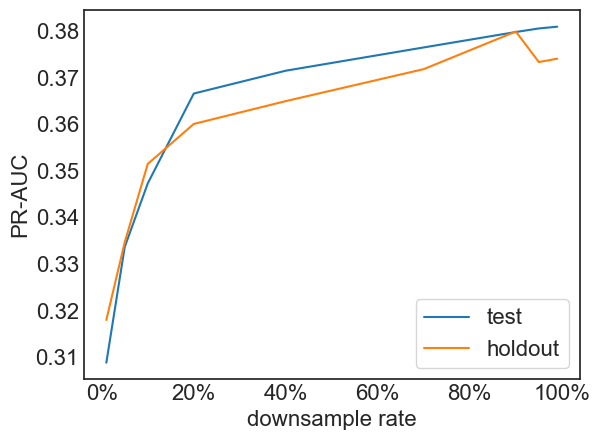

In [32]:
fig = sbnn_plot.plot_metric_dependence(metrics, xformatter = ticker.PercentFormatter(1),
                                      ylabel='PR-AUC',
                            xlabel='downsample rate')
fig.savefig(Path(setup.temp_path).joinpath('31_PLOT_average_precision.png'),
            bbox_inches='tight')

##### History

In [33]:
importlib.reload(sbnn_plot)

<module 'sba_nn.sba_nn.sbnn_plot' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_plot.py'>

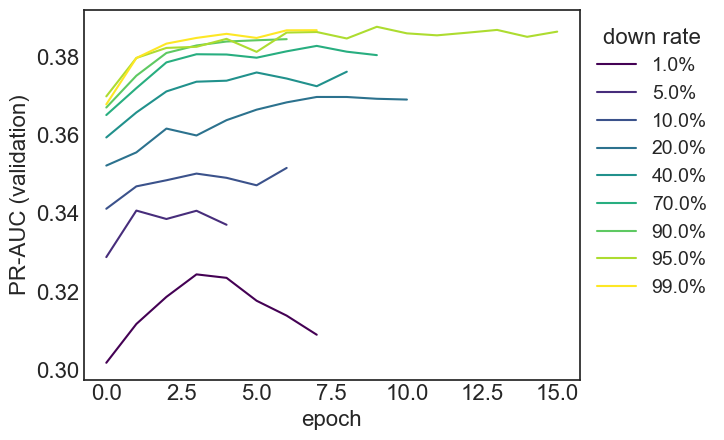

In [34]:
fig = sbnn_plot.plot_history_group(history,
                                  col_format_func = lambda x:f'{float(x):.1%}',
                                  ylabel = 'PR-AUC (validation)',
                                  leg_title='down rate')
fig.savefig(Path(setup.temp_path).joinpath('31_PLOT_hostory_val_auc.png'),
            bbox_inches='tight')

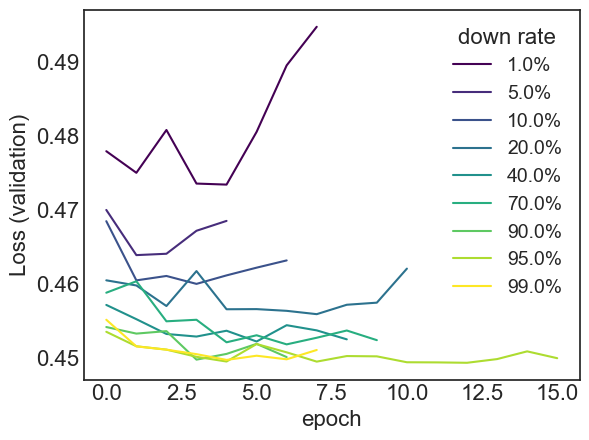

In [35]:
fig = sbnn_plot.plot_history_group(history,'val_loss',
                                  col_format_func = lambda x:f'{float(x):.1%}',
                                  ylabel = 'Loss (validation)',
                                  leg_title='down rate')
fig.savefig(Path(setup.temp_path).joinpath('31_PLOT_hostory_val_loss.png'),
            bbox_inches='tight')

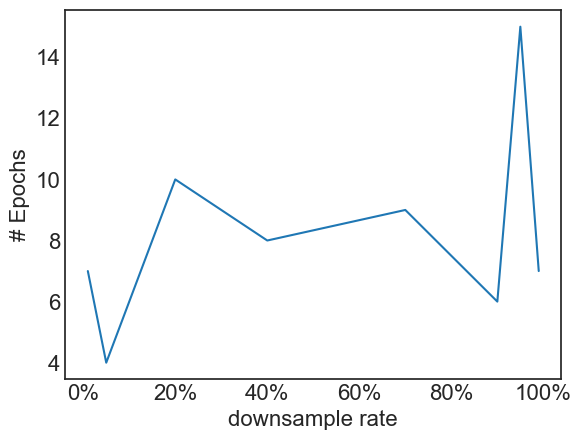

In [36]:
fig = sbnn_plot.plot_epoch_agg(history,
                               xformatter = ticker.PercentFormatter(1),
                               ylabel='# Epochs',
                               xlabel='downsample rate')
fig.savefig(Path(setup.temp_path).joinpath('31_PLOT_hostory_epochs.png'),
            bbox_inches='tight')